# Experiment description
## Hypothesis: 
Predictability values are similar considering different date intervals
## Method: 
- Remove outliers
- Measure predictability for 7 days timewindows and levelCrime=3 on intervals (months, bimesters, semesters)
- Implement a metric to compare the difference among predictability values

## Parameters: 
- Time windows: 7
- Crime levels: 3
- Aggregation: city and localidades

## Built-in methods

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import pickle
import matplotlib.pyplot as plt
import scipy
import math
from math import pi
import geopandas as gpd
%matplotlib inline

In [70]:
def set_initial_dataset_day(df_by_date,name_day):
    df_by_date = df_by_date.reset_index()
    df_by_date['day_of_week'] = df_by_date['date'].dt.day_name()
    monday_idx = df_by_date.index[df_by_date['day_of_week'] == name_day].tolist()[0]
    print('monday_idx',monday_idx)
    df_by_date = df_by_date[monday_idx:].set_index('date').drop(['day_of_week'],axis=1)
    return df_by_date

In [3]:
# Methods for time windows
def im2patches(im,n):
    patches = [];
    for i in range(len(im)-n):
        patch = im[i:(i+n-1)]        
        patch = patch - np.nanmean(patch);
        if(np.linalg.norm(patch)>0):
            patch = patch/np.linalg.norm(patch);
        if i==0:
            patches = patch;
        else:
            patches = np.vstack((patches,patch))
    return patches;

def writeEmbeding(timeSeries,lenWindow,samplePath, scenarioName):
    slicingWindows = im2patches(timeSeries,lenWindow);
    workingPath = '/Users/anamaria/Desktop/dev/security_project/periodicity_experiments/predictability/slicing/'
    prevStation = str(samplePath);
    with open(workingPath+'slicingWindows'+"_"+str(prevStation)+"_"+str(scenarioName)+"_"+str(lenWindow)+'_.pickle', 'wb') as f:
        lv = slicingWindows.tolist();                        
        pickle.dump(lv, f, protocol=2)

    workingPath = '/Users/anamaria/Desktop/dev/security_project/periodicity_experiments/predictability/timeSeries/'    
    with open(workingPath+'timeSeries'+"_"+str(prevStation)+"_"+str(scenarioName)+"_"+str(lenWindow)+'_.pickle', 'wb') as f:
        lv = timeSeries.tolist();                        
        pickle.dump(lv, f, protocol=2)



In [4]:
#Methods for predictability
def getBarcode(samplePath,lenWindow,scenarioName):
    workingPath = '/Users/anamaria/Desktop/dev/security_project/periodicity_experiments/predictability/'
    barcode = [];

    with open(workingPath+'timeSeries/'+'timeSeries_'+samplePath+"_"+str(scenarioName)+'_'+str(lenWindow)+'_'+'.pickle', 'rb') as f:
            timeSeries = pickle.load(f);            
    return (barcode,timeSeries);

def computeBarcodeEntropy(barsLenB0):
    barlen = np.array(barsLenB0);
    barlen = barlen/barlen.sum();
    hbc = 0;
    for i in range(barlen.shape[0]):
        if barlen[i]!=0:
            hbc = hbc-(barlen[i])*np.log(barlen[i]);
    return hbc;


def computeGeneralPredictability(timeSeries,binsData,lenWindow):
    # Colwell, R. K. (1974). Predictability, constancy, and contingency of periodic phenomena. Ecology, 55(5), 1148-1153.
    # Normalize the caudal values
    nLevels = binsData.shape[0]-1;
    matStations = np.array(timeSeries).reshape((np.array(timeSeries).shape[0]//lenWindow,lenWindow))    

    grandMean = np.mean(np.mean(matStations));
    #matStations = matStations / grandMean;
    N = np.zeros((nLevels,lenWindow));
    for i in range(1,matStations.shape[1]): 
        # Computes histograms per columns
        hist, bin_edges = np.histogram(matStations[:,i],bins = binsData);
        N[:,i] = hist;
    X = np.sum(N, axis=0);
    Y = np.sum(N, axis=1);
    Z = np.sum(Y);
    hx = 0;
    hy = 0;
    hxy = 0;
    for j in range(X.shape[0]):
        if X[j]!=0:
            hx = hx-(X[j]/Z)*np.log(X[j]/Z);
            
    for i in range(Y.shape[0]):
        if Y[i]!=0:
            hy = hy-(Y[i]/Z)*np.log(Y[i]/Z);
            
    for i in range(Y.shape[0]):
        for j in range(X.shape[0]):
            if N[i,j]!=0:
                hxy = hxy-((N[i,j]/Z)*np.log(N[i,j]/Z));    
    
    # predictability
    p = 1 - (hxy - hx)/np.log(N.shape[0]);
    # constancy
    c = 1 - hy/np.log(N.shape[0]);
    # Returns constancy and contingency
    return (c,p-c,p);



In [83]:
def preprocess_df(df,min_date_period,max_date_period):
    df=df.drop(columns=['PERIODO_TS','LOCALIDAD'])
    #Remove outliers
    q_hi = df["total_eventos"].quantile(0.99)
    df = df[(df["total_eventos"] < q_hi)]
    print('remove outliers')
    print(df.head(3))

    #Make sure dataset include consecutive dates in period
    idx = pd.date_range(min_date_period, max_date_period)
    df = df.reindex(idx, fill_value=int(df["total_eventos"].mean()))
    df = df.reset_index().rename(columns={'index': 'date'}).set_index('date')
    print('set consecutive dates')
    print(df.head(3))
    
    #Make sure dataset starts on Monday for the experiment
    df = set_initial_dataset_day(df,'Monday')
    print('starts on monday')
    print(df.head(3))
    
    return df

In [84]:
def saveTimeSeries(df,min_date_period,max_date_period,localidad, lenWindow, expName):       
    df_values = pd.Series(df['total_eventos']).values
    lT=get_LT(df, lenWindow)
    df_values = df_values[0:lT]
    print(lT, len(df_values))
    writeEmbeding(df_values,lenWindow,expName,localidad)

In [85]:
def get_LT(df_by_period,lenWindow):
    min_date = df_by_period.reset_index().date.min()
    max_date = df_by_period.reset_index().date.max()
    print('min date on localidad',min_date)
    print('max date on localidad',max_date)
    samples_num = (max_date.date()-min_date.date()).days
    print('samples_num',samples_num)
    lT = samples_num//lenWindow * lenWindow
    print('lT complete',samples_num/lenWindow)
    print('lT aprox',samples_num//lenWindow)
    return lT

In [86]:
def predictability_experiment_localidades(df_by_date,min_date_period,max_date_period,lenWindow,localidadesList,Levels,expName,periodName):
    workingPath = '/Users/anamaria/Desktop/dev/security_project/periodicity_experiments/predictability/';

    flagF = True;
    for localidad in localidadesList:
        print(localidad)
        #write embeding
        df_by_localidad = df_by_date[df_by_date['LOCALIDAD'] == localidad]        
        df_by_localidad = preprocess_df(df_by_localidad,min_date_period,max_date_period)
        saveTimeSeries(df_by_localidad,min_date_period,max_date_period,localidad, lenWindow, expName)
        
        for nLevels in Levels:
            (barcode,timeSeries) = getBarcode(expName,lenWindow,localidad);
            binsLevels = np.linspace(np.min(timeSeries),np.max(timeSeries),nLevels);
            c,m,p = computeGeneralPredictability(timeSeries,binsLevels,lenWindow)

            if flagF==True:
                flagF = False
                predValues = np.array([expName,periodName,localidad,lenWindow,nLevels,p,m,c]);
            else:
                predValues = np.vstack((predValues, [expName,periodName,localidad,lenWindow,nLevels,p,m,c]))

    return predValues
        
    

In [9]:
def table_predictability_by_period_report(df_agressiveBehavior,lenWindow,localidadesList,yAxisCategories,name_experiment):
    join=df_agressiveBehavior.pivot('localidad','period','predictability')
    var1_order = []
    var2_order = yAxisCategories
    if len(var2_order) > 0:
        join = join.reindex(var2_order, axis=1)
    if len(var1_order) > 0:
        join = join.reindex(var1_order)
    
    fig, ax = plt.subplots(1,1,sharex=True, sharey=True)
    fig.set_size_inches(7, 6)
    g=sns.heatmap(join.astype('float'),annot=True,fmt=".3",linewidths=0,cmap="Blues",cbar=False)
    g.set_yticklabels(g.get_yticklabels(), rotation = 0)
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    file_path = '/Users/anamaria/Desktop/dev/security_project/periodicity_experiments/predictability/figures/'
    plt.savefig(file_path+'table_'+str(name_experiment)+'_predictability_time_'+str(lenWindow)+'_levels_',dpi=300,bbox_inches = "tight")
    plt.show()

In [10]:
def map_localidad(ax,df,col_localidad,col_vals,vmin=None,vmax=None):
  loc_geo="/Users/anamaria/Desktop/dev/security_project/assets/localidades_polygon.json"
  loc_=gpd.read_file(loc_geo)
  loc_=loc_.merge(df,left_on='LocNombre',right_on=col_localidad)
  loc_.plot(cmap='viridis',column=col_vals,legend=True,ax=ax,vmin=vmin,vmax=vmax)  

In [11]:
def map_predictability(df_crime, crime_level, lenWindow,name_experiment):
    subdata = df_crime[df_crime['crime_level']==crime_level]
    subdata = subdata[subdata['lenWindow']==str(lenWindow)]
    subdata["predictability"] = pd.to_numeric(subdata["predictability"])
    
    fig, ax = plt.subplots(figsize=(12,12))
    map_localidad(ax,subdata,'localidad','predictability')
    ax.axis('off')
    file_path = '/Users/anamaria/Desktop/dev/security_project/periodicity_experiments/predictability/figures/'
    plt.savefig(file_path+'map_aggressiveBehavior_localidades'+str(name_experiment)+'_predictability_time_'+str(lenWindow)+'_levels_'+str(crime_level),dpi=300,bbox_inches = "tight")
    plt.show()

In [12]:
def build_semester_list(year,semester=1):
    if semester == 1:
        month_list = ['01','02','03','04','05','06']
    if semester == 2:
        month_list = ['07','08','09','10','11','12']
    semester_list = map(lambda m: year+'/'+str(m), month_list)
    return (list(semester_list))

def build_trimester_list(year,trimester=1):
    if trimester == 1:
        month_list = ['01','02','03']
    if trimester == 2:
        month_list = ['04','05','06']
    if trimester == 3:
        month_list = ['07','08','09']
    if trimester == 4:
        month_list = ['10','11','12']
    trimester_list = map(lambda m: year+'/'+str(m), month_list)
    return (list(trimester_list))

def build_bimester_list(year,bimester=1):
    if bimester == 1:
        month_list = ['01','02']
    if bimester == 2:
        month_list = ['03','04']
    if bimester == 3:
        month_list = ['05','06']
    if bimester == 4:
        month_list = ['07','08']
    if bimester == 5:
        month_list = ['09','10']
    if bimester == 6:
        month_list = ['11','12']
    bimester_list = map(lambda m: year+'/'+str(m), month_list)
    return (list(bimester_list))

## Load data

In [13]:
data_location = '/Users/anamaria/Desktop/dev/security_project/datasets/verify_enrich_nuse_29112019.csv'
df_input = pd.read_csv(data_location,delimiter=",")

In [14]:
df_input['date']=pd.to_datetime(df_input['FECHA'])
df_by_date = pd.DataFrame(df_input.groupby(['date','PERIODO_TS','LOCALIDAD']).size(),columns=["total_eventos"])

In [15]:
df_by_date = df_by_date.reset_index().set_index('date')

## Localidades, semester

In [89]:
Levels=[5]
lenWindow = 7
levelCategories = list(map(lambda x: str(x), Levels))
localidadesList = list(df_by_date.LOCALIDAD.unique())
localidadesList.remove('SIN LOCALIZACION')

In [90]:
years = list(df_input['ANIO'].unique())
years.remove(2019)
semesters = [1, 2]

['2017/01', '2017/02', '2017/03', '2017/04', '2017/05', '2017/06']
min date on period 2017-01-01 00:00:00
max_date_on_period 2017-06-30 00:00:00
ANTONIO NARIÑO
remove outliers
            total_eventos
date                     
2017-01-01             24
2017-01-02              8
2017-01-03             19
set consecutive dates
            total_eventos
date                     
2017-01-01             24
2017-01-02              8
2017-01-03             19
monday_idx 1
starts on monday
            total_eventos
date                     
2017-01-02              8
2017-01-03             19
2017-01-04             13
min date on localidad 2017-01-02 00:00:00
max date on localidad 2017-06-30 00:00:00
samples_num 179
lT complete 25.571428571428573
lT aprox 25
175 175
BARRIOS UNIDOS
remove outliers
            total_eventos
date                     
2017-01-01             34
2017-01-02             12
2017-01-03             15
set consecutive dates
            total_eventos
date                  

min date on localidad 2017-01-02 00:00:00
max date on localidad 2017-06-30 00:00:00
samples_num 179
lT complete 25.571428571428573
lT aprox 25
175 175
TUNJUELITO
remove outliers
            total_eventos
date                     
2017-01-02             23
2017-01-03             18
2017-01-04             21
set consecutive dates
            total_eventos
date                     
2017-01-01             26
2017-01-02             23
2017-01-03             18
monday_idx 1
starts on monday
            total_eventos
date                     
2017-01-02             23
2017-01-03             18
2017-01-04             21
min date on localidad 2017-01-02 00:00:00
max date on localidad 2017-06-30 00:00:00
samples_num 179
lT complete 25.571428571428573
lT aprox 25
175 175
USAQUEN
remove outliers
            total_eventos
date                     
2017-01-02             44
2017-01-03             57
2017-01-04             41
set consecutive dates
            total_eventos
date                     
2

RAFAEL URIBE URIBE
remove outliers
            total_eventos
date                     
2017-07-01             89
2017-07-02            104
2017-07-03             63
set consecutive dates
            total_eventos
date                     
2017-07-01             89
2017-07-02            104
2017-07-03             63
monday_idx 2
starts on monday
            total_eventos
date                     
2017-07-03             63
2017-07-04             43
2017-07-05             39
min date on localidad 2017-07-03 00:00:00
max date on localidad 2017-12-31 00:00:00
samples_num 181
lT complete 25.857142857142858
lT aprox 25
175 175
SAN CRISTOBAL
remove outliers
            total_eventos
date                     
2017-07-01             88
2017-07-02            101
2017-07-03             72
set consecutive dates
            total_eventos
date                     
2017-07-01             88
2017-07-02            101
2017-07-03             72
monday_idx 2
starts on monday
            total_eventos
date

ENGATIVA
remove outliers
            total_eventos
date                     
2018-01-02             44
2018-01-03             96
2018-01-04             54
set consecutive dates
            total_eventos
date                     
2018-01-01             97
2018-01-02             44
2018-01-03             96
monday_idx 0
starts on monday
            total_eventos
date                     
2018-01-01             97
2018-01-02             44
2018-01-03             96
min date on localidad 2018-01-01 00:00:00
max date on localidad 2018-06-30 00:00:00
samples_num 180
lT complete 25.714285714285715
lT aprox 25
175 175
FONTIBON
remove outliers
            total_eventos
date                     
2018-01-02             20
2018-01-03             30
2018-01-04             35
set consecutive dates
            total_eventos
date                     
2018-01-01             41
2018-01-02             20
2018-01-03             30
monday_idx 0
starts on monday
            total_eventos
date               

monday_idx 1
starts on monday
            total_eventos
date                     
2018-07-02             20
2018-07-03             38
2018-07-04             27
min date on localidad 2018-07-02 00:00:00
max date on localidad 2018-12-31 00:00:00
samples_num 182
lT complete 26.0
lT aprox 26
182 182
BOSA
remove outliers
            total_eventos
date                     
2018-07-01            153
2018-07-02            104
2018-07-03            108
set consecutive dates
            total_eventos
date                     
2018-07-01            153
2018-07-02            104
2018-07-03            108
monday_idx 1
starts on monday
            total_eventos
date                     
2018-07-02            104
2018-07-03            108
2018-07-04             83
min date on localidad 2018-07-02 00:00:00
max date on localidad 2018-12-31 00:00:00
samples_num 182
lT complete 26.0
lT aprox 26
182 182
CANDELARIA
remove outliers
            total_eventos
date                     
2018-07-01             1

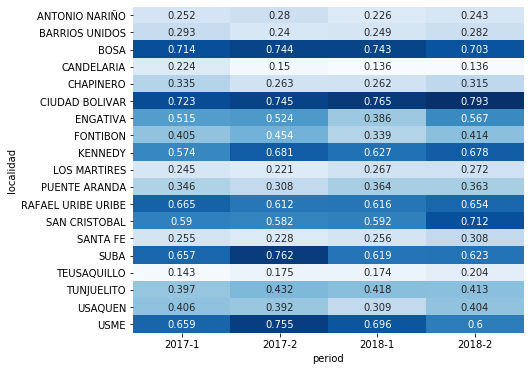

In [91]:
predValues_array = []
for year in years:
    for semester in semesters:
        period_list = build_semester_list(str(year),semester)
        print(period_list)
        df_by_period=df_by_date[df_by_date.PERIODO_TS.isin(period_list)]
        #df_by_period = set_initial_dataset_day(df_by_period,'Monday')

        min_date_on_period = df_by_period.reset_index().date.min()
        max_date_on_period = df_by_period.reset_index().date.max()
        print('min date on period',min_date_on_period)
        print('max_date_on_period',max_date_on_period)

        expName = 'prueba_localidad_by_semester'
        periodName = str(year)+'-'+str(semester)
        predValues = predictability_experiment_localidades(df_by_period,min_date_on_period,max_date_on_period,lenWindow,localidadesList,Levels,expName,periodName)
        predValues_array = predValues_array + list(predValues)
    
df_prediction = pd.DataFrame(predValues_array, columns=['experiment_name','period','localidad','lenWindow','crime_level','predictability','contingency','constancy'])
periodCategories = list(df_prediction['period'].unique())
table_predictability_by_period_report(df_prediction,lenWindow,localidadesList,periodCategories,expName)



## Localidades, trimester

In [57]:
Levels=[3]
lenWindow = 7
levelCategories = list(map(lambda x: str(x), Levels))
localidadesList = list(df_by_date.LOCALIDAD.unique())
localidadesList.remove('SIN LOCALIZACION')

In [58]:
years = list(df_input['ANIO'].unique())
years.remove(2019)
trimesters = [1, 2, 3, 4]

['2017/01', '2017/02', '2017/03']
2017-01-01 00:00:00 2017-03-31 00:00:00
ANTONIO NARIÑO
remove outliers
            total_eventos
date                     
2017-01-01             24
2017-01-02              8
2017-01-03             19
set consecutive dates
            total_eventos
date                     
2017-01-01             24
2017-01-02              8
2017-01-03             19
monday_idx 1
starts on monday
            total_eventos
date                     
2017-01-02              8
2017-01-03             19
2017-01-04             13
min date on localidad 2017-01-02 00:00:00
max date on localidad 2017-03-31 00:00:00
samples_num 88
lT complete 12.571428571428571
lT aprox 12
84 84
BARRIOS UNIDOS
remove outliers
            total_eventos
date                     
2017-01-01             34
2017-01-02             12
2017-01-03             15
set consecutive dates
            total_eventos
date                     
2017-01-01             34
2017-01-02             12
2017-01-03        

min date on localidad 2017-01-02 00:00:00
max date on localidad 2017-03-31 00:00:00
samples_num 88
lT complete 12.571428571428571
lT aprox 12
84 84
['2017/04', '2017/05', '2017/06']
2017-04-01 00:00:00 2017-06-30 00:00:00
ANTONIO NARIÑO
remove outliers
            total_eventos
date                     
2017-04-01             21
2017-04-02             34
2017-04-03             22
set consecutive dates
            total_eventos
date                     
2017-04-01             21
2017-04-02             34
2017-04-03             22
monday_idx 2
starts on monday
            total_eventos
date                     
2017-04-03             22
2017-04-04             13
2017-04-05             11
min date on localidad 2017-04-03 00:00:00
max date on localidad 2017-06-30 00:00:00
samples_num 88
lT complete 12.571428571428571
lT aprox 12
84 84
BARRIOS UNIDOS
remove outliers
            total_eventos
date                     
2017-04-01             33
2017-04-02             33
2017-04-03            

remove outliers
            total_eventos
date                     
2017-04-01             40
2017-04-02             45
2017-04-03             34
set consecutive dates
            total_eventos
date                     
2017-04-01             40
2017-04-02             45
2017-04-03             34
monday_idx 2
starts on monday
            total_eventos
date                     
2017-04-03             34
2017-04-04             21
2017-04-05             29
min date on localidad 2017-04-03 00:00:00
max date on localidad 2017-06-30 00:00:00
samples_num 88
lT complete 12.571428571428571
lT aprox 12
84 84
USAQUEN
remove outliers
            total_eventos
date                     
2017-04-01            113
2017-04-03             44
2017-04-04             56
set consecutive dates
            total_eventos
date                     
2017-04-01            113
2017-04-02             62
2017-04-03             44
monday_idx 2
starts on monday
            total_eventos
date                     
2017-0

set consecutive dates
            total_eventos
date                     
2017-07-01             30
2017-07-02             22
2017-07-03             24
monday_idx 2
starts on monday
            total_eventos
date                     
2017-07-03             24
2017-07-04             11
2017-07-05             17
min date on localidad 2017-07-03 00:00:00
max date on localidad 2017-09-30 00:00:00
samples_num 89
lT complete 12.714285714285714
lT aprox 12
84 84
SUBA
remove outliers
            total_eventos
date                     
2017-07-01            191
2017-07-02            262
2017-07-03            159
set consecutive dates
            total_eventos
date                     
2017-07-01            191
2017-07-02            262
2017-07-03            159
monday_idx 2
starts on monday
            total_eventos
date                     
2017-07-03            159
2017-07-04            110
2017-07-05             97
min date on localidad 2017-07-03 00:00:00
max date on localidad 2017-09-30 00

monday_idx 1
starts on monday
            total_eventos
date                     
2017-10-02             20
2017-10-03             39
2017-10-04             27
min date on localidad 2017-10-02 00:00:00
max date on localidad 2017-12-31 00:00:00
samples_num 90
lT complete 12.857142857142858
lT aprox 12
84 84
RAFAEL URIBE URIBE
remove outliers
            total_eventos
date                     
2017-10-01            102
2017-10-02             46
2017-10-03             35
set consecutive dates
            total_eventos
date                     
2017-10-01            102
2017-10-02             46
2017-10-03             35
monday_idx 1
starts on monday
            total_eventos
date                     
2017-10-02             46
2017-10-03             35
2017-10-04             39
min date on localidad 2017-10-02 00:00:00
max date on localidad 2017-12-31 00:00:00
samples_num 90
lT complete 12.857142857142858
lT aprox 12
84 84
SAN CRISTOBAL
remove outliers
            total_eventos
date       

remove outliers
            total_eventos
date                     
2018-01-02             20
2018-01-03             30
2018-01-04             35
set consecutive dates
            total_eventos
date                     
2018-01-01             41
2018-01-02             20
2018-01-03             30
monday_idx 0
starts on monday
            total_eventos
date                     
2018-01-01             41
2018-01-02             20
2018-01-03             30
min date on localidad 2018-01-01 00:00:00
max date on localidad 2018-03-31 00:00:00
samples_num 89
lT complete 12.714285714285714
lT aprox 12
84 84
KENNEDY
remove outliers
            total_eventos
date                     
2018-01-02             78
2018-01-03            125
2018-01-04            103
set consecutive dates
            total_eventos
date                     
2018-01-01            139
2018-01-02             78
2018-01-03            125
monday_idx 0
starts on monday
            total_eventos
date                     
2018-0

CIUDAD BOLIVAR
remove outliers
            total_eventos
date                     
2018-04-01            142
2018-04-02             70
2018-04-03             55
set consecutive dates
            total_eventos
date                     
2018-04-01            142
2018-04-02             70
2018-04-03             55
monday_idx 1
starts on monday
            total_eventos
date                     
2018-04-02             70
2018-04-03             55
2018-04-04             62
min date on localidad 2018-04-02 00:00:00
max date on localidad 2018-06-30 00:00:00
samples_num 89
lT complete 12.714285714285714
lT aprox 12
84 84
ENGATIVA
remove outliers
            total_eventos
date                     
2018-04-01             96
2018-04-02             79
2018-04-03             74
set consecutive dates
            total_eventos
date                     
2018-04-01             96
2018-04-02             79
2018-04-03             74
monday_idx 1
starts on monday
            total_eventos
date            

min date on localidad 2018-07-02 00:00:00
max date on localidad 2018-09-30 00:00:00
samples_num 90
lT complete 12.857142857142858
lT aprox 12
84 84
BOSA
remove outliers
            total_eventos
date                     
2018-07-01            153
2018-07-02            104
2018-07-03            108
set consecutive dates
            total_eventos
date                     
2018-07-01            153
2018-07-02            104
2018-07-03            108
monday_idx 1
starts on monday
            total_eventos
date                     
2018-07-02            104
2018-07-03            108
2018-07-04             83
min date on localidad 2018-07-02 00:00:00
max date on localidad 2018-09-30 00:00:00
samples_num 90
lT complete 12.857142857142858
lT aprox 12
84 84
CANDELARIA
remove outliers
            total_eventos
date                     
2018-07-01             11
2018-07-02              4
2018-07-03             11
set consecutive dates
            total_eventos
date                     
2018-07-01

monday_idx 0
starts on monday
            total_eventos
date                     
2018-10-01             26
2018-10-02             25
2018-10-03             28
min date on localidad 2018-10-01 00:00:00
max date on localidad 2018-12-31 00:00:00
samples_num 91
lT complete 13.0
lT aprox 13
91 91
BOSA
remove outliers
            total_eventos
date                     
2018-10-01             72
2018-10-02             72
2018-10-03             77
set consecutive dates
            total_eventos
date                     
2018-10-01             72
2018-10-02             72
2018-10-03             77
monday_idx 0
starts on monday
            total_eventos
date                     
2018-10-01             72
2018-10-02             72
2018-10-03             77
min date on localidad 2018-10-01 00:00:00
max date on localidad 2018-12-31 00:00:00
samples_num 91
lT complete 13.0
lT aprox 13
91 91
CANDELARIA
remove outliers
            total_eventos
date                     
2018-10-01             11
2018

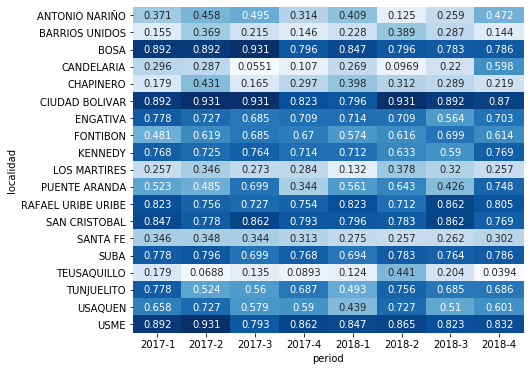

In [75]:
predValues_array = []
for year in years:
    for trimester in trimesters:
        period_list = build_trimester_list(str(year),trimester)
        print(period_list)
        df_by_period=df_by_date[df_by_date.PERIODO_TS.isin(period_list)]
        #df_by_period = set_initial_dataset_day(df_by_period,'Monday')

        min_date_on_period = df_by_period.reset_index().date.min()
        max_date_on_period = df_by_period.reset_index().date.max()
        print(min_date_on_period,max_date_on_period)

        expName = 'aggressiveBehavior_localidad_by_trimester'
        periodName = str(year)+'-'+str(trimester)
        predValues = predictability_experiment_localidades(df_by_period,min_date_on_period,max_date_on_period,lenWindow,localidadesList,Levels,expName,periodName)
        predValues_array = predValues_array + list(predValues)
    
df_prediction = pd.DataFrame(predValues_array, columns=['experiment_name','period','localidad','lenWindow','crime_level','predictability','contingency','constancy'])
periodCategories = list(df_prediction['period'].unique())
table_predictability_by_period_report(df_prediction,lenWindow,localidadesList,periodCategories,expName)



['2017/07', '2017/08', '2017/09', '2017/10', '2017/11', '2017/12']


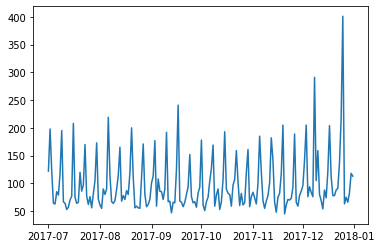

In [82]:
df=df_by_date[df_by_date['LOCALIDAD'] == 'BOSA']
period_list = build_semester_list(str(2017),2)
print(period_list)
df=df[df.PERIODO_TS.isin(period_list)]
df
plt.plot(df.drop(columns=['PERIODO_TS','LOCALIDAD']))
